In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Getting the data

In [3]:
!kaggle datasets download -d datamunge/sign-language-mnist

 99% 62.0M/62.6M [00:04<00:00, 18.6MB/s]
100% 62.6M/62.6M [00:04<00:00, 15.1MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile("/content/sign-language-mnist.zip")
zip_ref.extractall()
zip_ref.close()

In [5]:
!ls /content/sign_mnist_train

sign_mnist_train.csv


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import array_to_img, ImageDataGenerator
from keras import layers, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [7]:
# train dataset
train_df = pd.read_csv("/content/sign_mnist_train/sign_mnist_train.csv")

# test dataset
test_df = pd.read_csv("/content/sign_mnist_test/sign_mnist_test.csv")

In [8]:
len(train_df), len(test_df)

(27455, 7172)

In [9]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [10]:
train_df.isna().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [11]:
train_df.shape

(27455, 785)

In [12]:
def process_img(dataframe):
  # Extract labels and pixel values
  labels = dataframe['label'].values.astype(np.int32)
  images = dataframe.drop('label', axis=1).values.astype(np.float32)

  # Reshape images to (num_samples, 28, 28)
  images = images.reshape(-1, 28, 28)
  return images, labels

In [13]:
# getting train and test images and labels
train_img, train_labels = process_img(train_df)
val_img, val_labels = process_img(test_df)

print(f"Shape of Training Images: {train_img.shape}")
print(f"Shape of Training Labels: {train_labels.shape}")
print(f"Shape of Val Images: {val_img.shape}")
print(f"Shape of Val Labels: {val_labels.shape}")

Shape of Training Images: (27455, 28, 28)
Shape of Training Labels: (27455,)
Shape of Val Images: (7172, 28, 28)
Shape of Val Labels: (7172,)


In [14]:
import string

def plot_images(train_img, train_labels):
  fig, axes = plt.subplots(4, 5, figsize=(16,15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)
  for i in range(20):
    img = train_img[i]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[i]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(train_labels[i])]}")
  plt.tight_layout()
  plt.show()

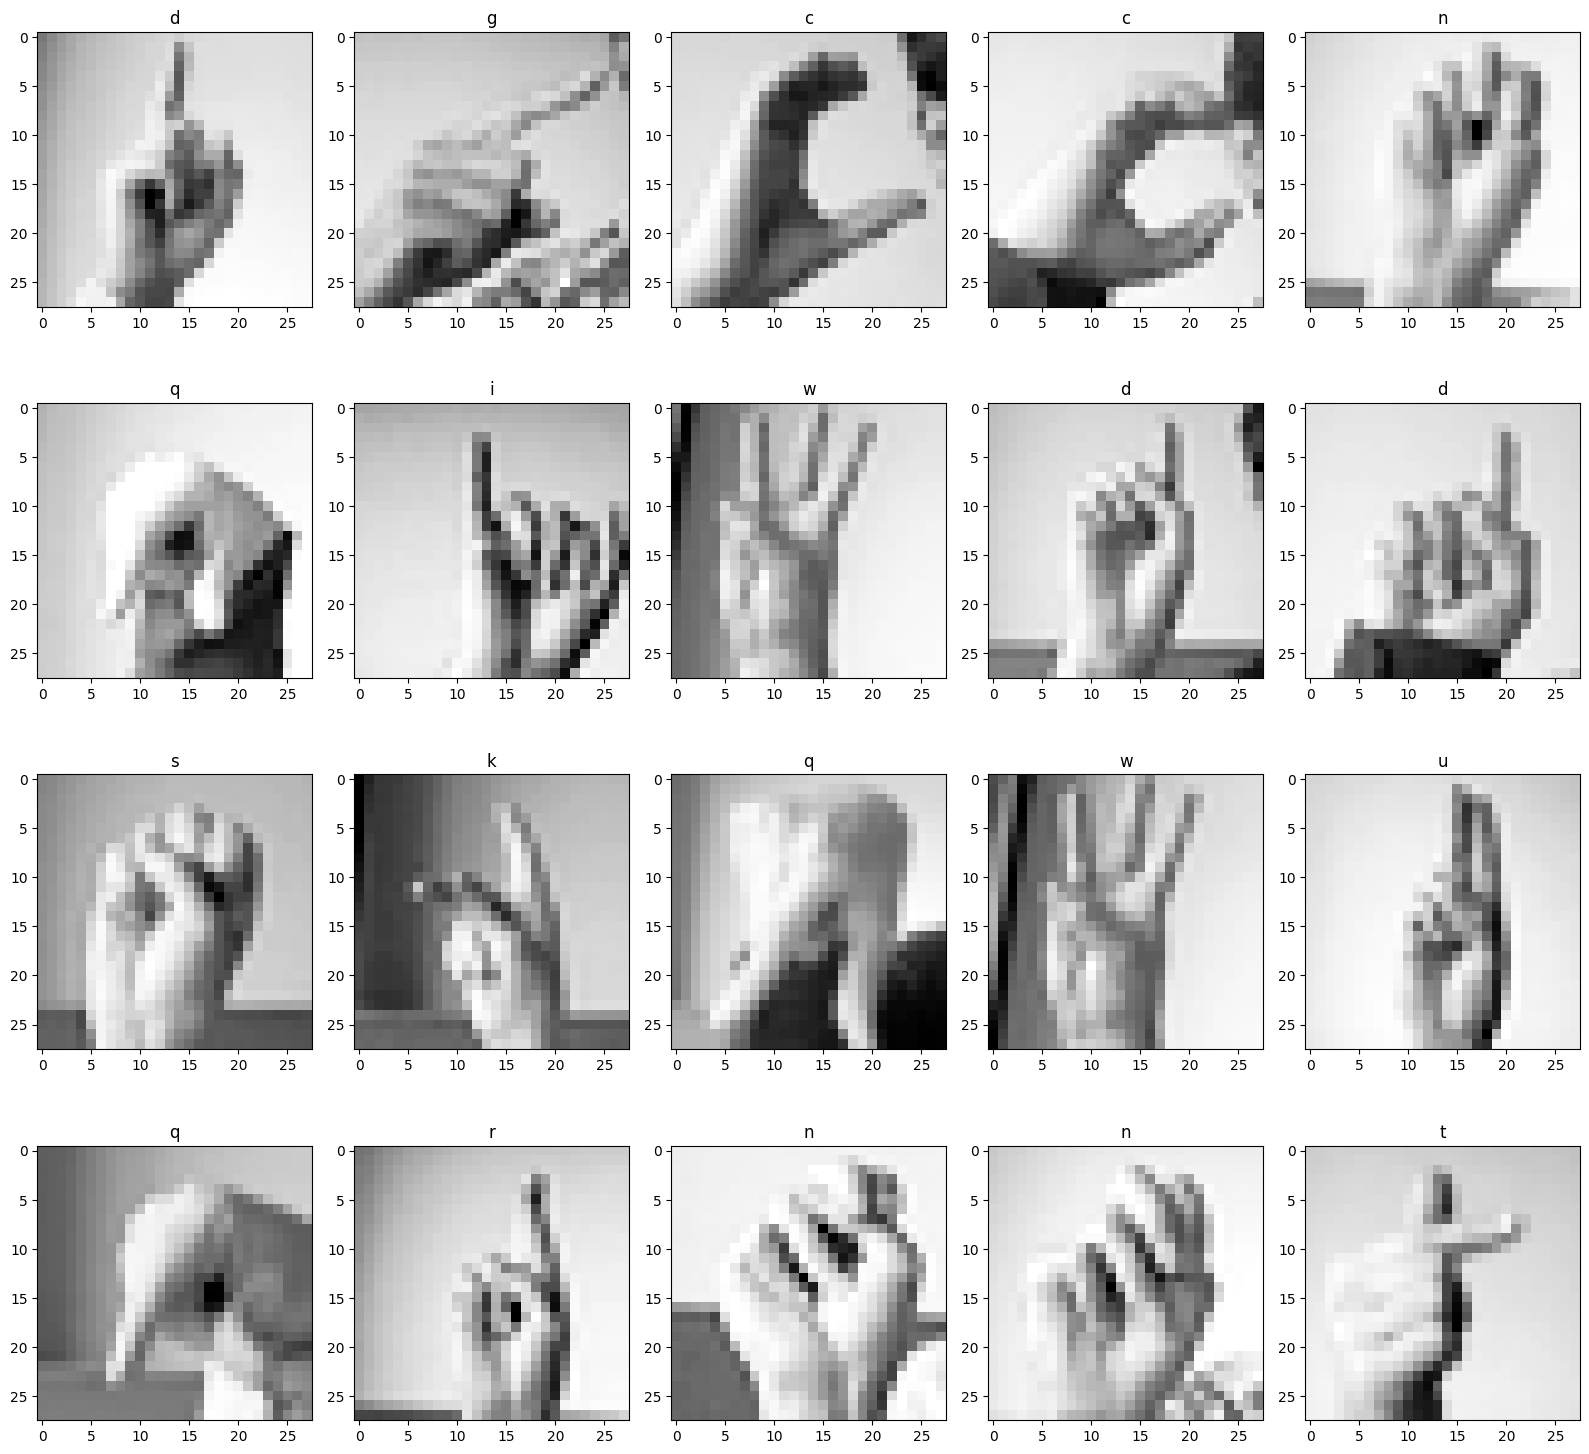

In [15]:
plot_images(train_img, train_labels)

# Preprocessing the data

In [16]:
train_df['label'].unique()

array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14])

In [17]:
# Getting classes
class_names = [chr(ord('a') + i) for i in range(26)]
print(f"Total Classes: {len(class_names)} and Class_Names: {class_names}")

Total Classes: 26 and Class_Names: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest' )

val_datagen = ImageDataGenerator(rescale=1./255)

train_images = np.expand_dims(train_img, axis = 3)
val_images = np.expand_dims(val_img, axis = 3)

train_data = train_datagen.flow(train_images, train_labels, batch_size=32)
val_data = val_datagen.flow(val_images, val_labels, batch_size=32)

# Creating a CNN Model

In [23]:
model = Sequential([
    layers.Conv2D(64, (5, 5), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)),
    layers.Conv2D(64, (5, 5), activation = 'relu', padding = 'same'),
    layers.MaxPool2D(2),

    layers.Dropout(0.2),

    layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    layers.MaxPool2D(2),

    layers.Dropout(0.2),
    layers.Flatten(),

    layers.Dense(256, activation = 'relu'),

    layers.Dropout(0.2),

    layers.Dense(len(class_names), activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        102464    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        9248      
                                                      

In [27]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [25]:
earlyStopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 1e-4,
    patience = 5,
    restore_best_weights = True
)

reduceLR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 3,
    factor = 0.5,
    min_lr = 1e-5
)

In [28]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 30,
    callbacks = [earlyStopping, reduceLR],
    workers = 4,
    use_multiprocessing = True
)

Epoch 1/30
858/858 [==============================] - 31s 25ms/step - loss: 2.9285 - accuracy: 0.1195 - val_loss: 1.8019 - val_accuracy: 0.4632 - lr: 0.0010
Epoch 2/30
858/858 [==============================] - 29s 34ms/step - loss: 1.7446 - accuracy: 0.4278 - val_loss: 0.6882 - val_accuracy: 0.7844 - lr: 0.0010
Epoch 3/30
858/858 [==============================] - 27s 31ms/step - loss: 1.1208 - accuracy: 0.6238 - val_loss: 0.4222 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 4/30
858/858 [==============================] - 24s 28ms/step - loss: 0.8644 - accuracy: 0.7032 - val_loss: 0.3145 - val_accuracy: 0.8880 - lr: 0.0010
Epoch 5/30
858/858 [==============================] - 23s 27ms/step - loss: 0.7144 - accuracy: 0.7523 - val_loss: 0.2043 - val_accuracy: 0.9322 - lr: 0.0010
Epoch 6/30
858/858 [==============================] - 23s 26ms/step - loss: 0.6272 - accuracy: 0.7874 - val_loss: 0.1405 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 7/30
858/858 [==============================] - 23s 

In [31]:
def loss_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label="Training_Loss")
    plt.plot(epochs, val_loss, label="Val_Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="Training_Accuracy1")
    plt.plot(epochs, val_accuracy, label="Val_Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


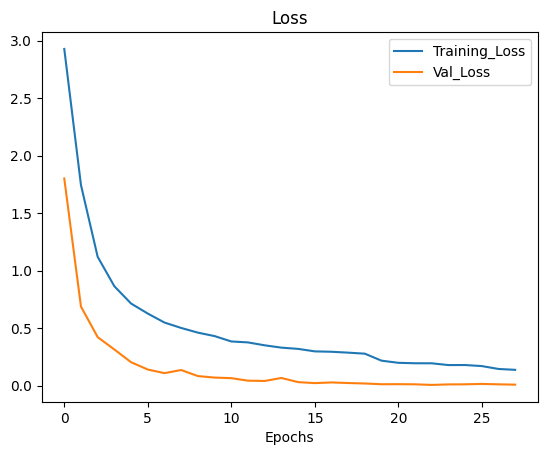

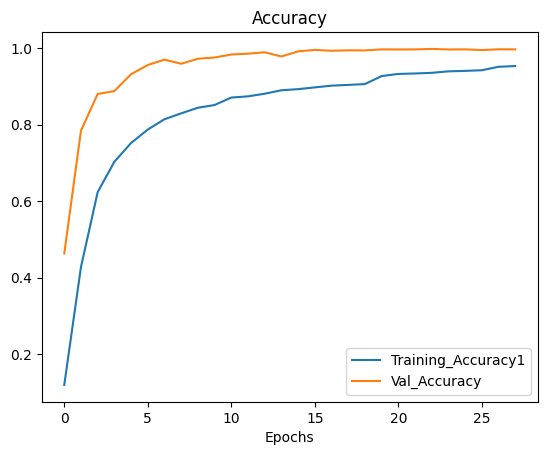

In [32]:
loss_curve(history)